In [1]:
%%capture
# Cell 1: Setup and Audio Download
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib

import torch
import torchaudio
import urllib
import numpy as np

def download_sample_audio():
    # url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    url = "file:///C:/Users/x/Downloads/LJ025-0076.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate


In [2]:

# Cell 2: Visualization Setup
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram


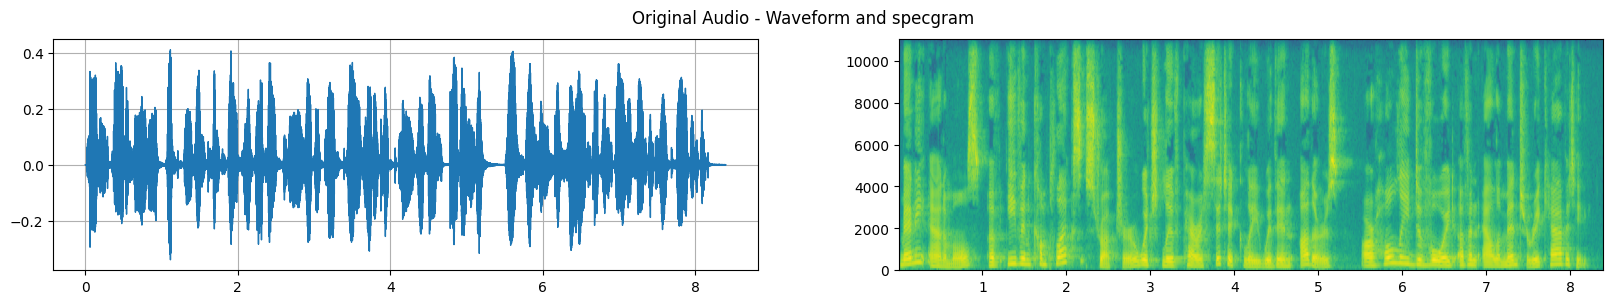

In [3]:

# Cell 3: Load Original Audio
audio, sr = download_sample_audio()
plot_waveform_and_specgram(audio, sr, title="Original Audio")
play_audio(audio, sr)


In [4]:

# Cell 4: Watermarking Setup
from audioseal import AudioSeal

# Load models
generator = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector("audioseal_detector_16bits")



--- Watermark 1 Embedding ---
SNR after Watermark 1: 27.45 dB


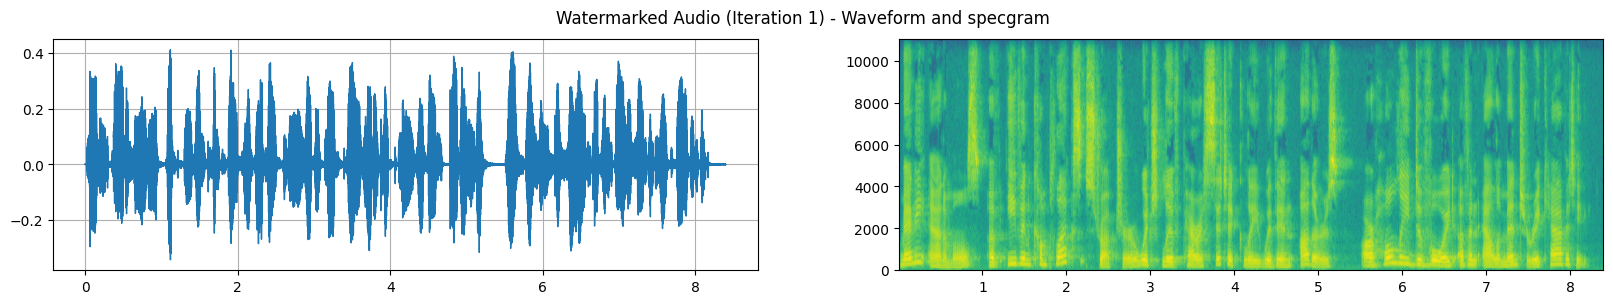

Watermark 1 Detection:
  Original Message:  [0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1]
  Detected Message:  [0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1]
  Probability: 1.0000
  Bit Error Rate: 0.0000

--- Watermark 2 Embedding ---
SNR after Watermark 2: 35.99 dB


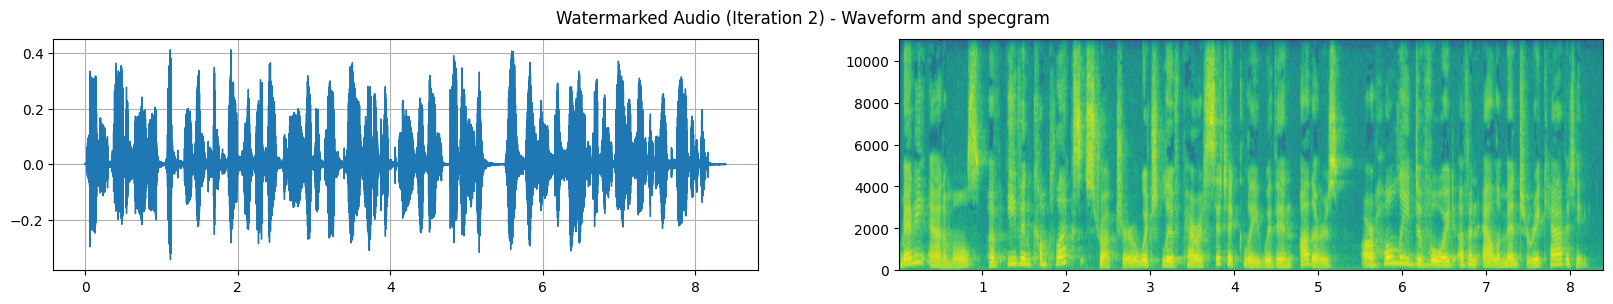

Watermark 1 Detection:
  Original Message:  [0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1]
  Detected Message:  [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0]
  Probability: 1.0000
  Bit Error Rate: 0.5625
Watermark 2 Detection:
  Original Message:  [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0]
  Detected Message:  [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0]
  Probability: 1.0000
  Bit Error Rate: 0.0000

--- Watermark 3 Embedding ---
SNR after Watermark 3: 41.97 dB


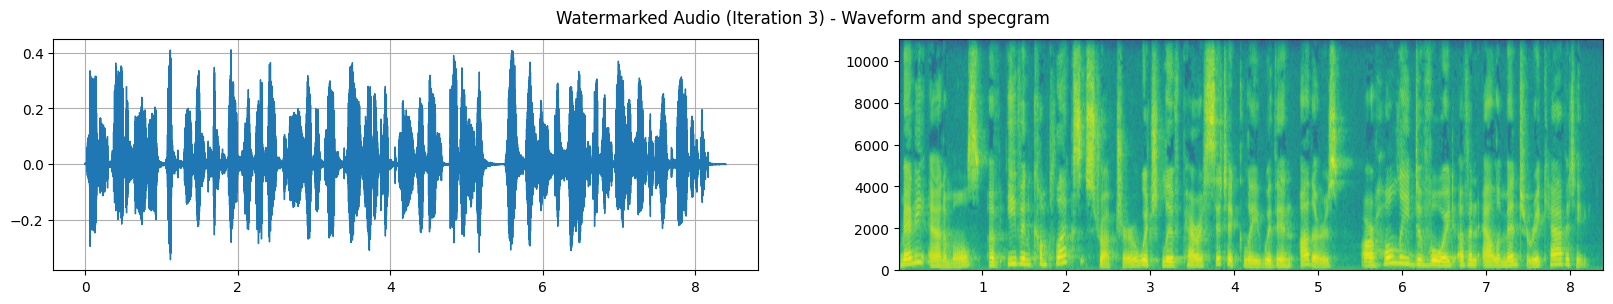

Watermark 1 Detection:
  Original Message:  [0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1]
  Detected Message:  [1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1]
  Probability: 1.0000
  Bit Error Rate: 0.3750
Watermark 2 Detection:
  Original Message:  [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0]
  Detected Message:  [1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1]
  Probability: 1.0000
  Bit Error Rate: 0.1875
Watermark 3 Detection:
  Original Message:  [1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1]
  Detected Message:  [1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1]
  Probability: 1.0000
  Bit Error Rate: 0.1250

--- Watermark 4 Embedding ---
SNR after Watermark 4: 48.35 dB


In [ ]:
# Cell 5: Multiple Watermarking Experiment
# Prepare audio for watermarking
audios = audio.unsqueeze(0)  # Add batch dimension

# Generate multiple unique messages
messages = [torch.randint(0, 2, (1, 16), dtype=torch.int32) for _ in range(4)]

# Watermarking parameters
watermarked_audio = audios.clone()
alphas = [1, 0.75, 0.5, 0.25]  # Reduced, more realistic strengths

# Tracking variables
snr_values = []
detection_results = []

# Perform multi-watermarking
for i, (msg, alpha) in enumerate(zip(messages, alphas), 1):
    print(f"\n--- Watermark {i} Embedding ---")
    
    # Generate watermark with specific message
    watermark = generator.get_watermark(
        watermarked_audio, 
        sample_rate=sr, 
        message=msg  # Explicitly use the generated message
    )
    
    # Store original audio for SNR calculation
    original_audio = watermarked_audio.clone()
    
    # Apply watermark
    watermarked_audio += alpha * watermark
    
    # Calculate Signal-to-Noise Ratio (SNR)
    noise = watermarked_audio - original_audio
    snr = 10 * torch.log10(original_audio.pow(2).mean() / noise.pow(2).mean())
    snr_values.append(snr.item())
    
    # Visualize watermarked audio
    print(f"SNR after Watermark {i}: {snr:.2f} dB")
    plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title=f"Watermarked Audio (Iteration {i})")
    play_audio(watermarked_audio, sr)
    
    # Detect watermarks
    watermark_detection_results = []
    for j, prev_msg in enumerate(messages[:i], 1):
        # Reset detector state
        detector.message = prev_msg
        
        # Detect watermark
        result, detected_msg = detector.detect_watermark(
            watermarked_audio, 
            sample_rate=sr, 
            message_threshold=0.5
        )
        
        # Calculate Bit Error Rate (BER)
        ber = (prev_msg != detected_msg.round()).float().mean()
        watermark_detection_results.append({
            'watermark': j,
            'detection_prob': result,
            'ber': ber,
            'original_msg': prev_msg.numpy().flatten(),
            'detected_msg': detected_msg.round().numpy().flatten()
        })
        
        print(f"Watermark {j} Detection:")
        print(f"  Original Message:  {prev_msg.numpy().flatten()}")
        print(f"  Detected Message:  {detected_msg.round().numpy().flatten()}")
        print(f"  Probability: {result:.4f}")
        print(f"  Bit Error Rate: {ber:.4f}")
    
    detection_results.append(watermark_detection_results)

In [ ]:
# Cell 6: Summary of Results
print("\n--- Multi-Watermarking Summary ---")
print("Signal-to-Noise Ratios (SNR):", [f"{snr:.2f}" for snr in snr_values])

print("\nDetection Results:")
for i, iteration_results in enumerate(detection_results, 1):
    print(f"\nAfter Watermark {i}:")
    for result in iteration_results:
        print(f"  Watermark {result['watermark']}: Prob = {result['detection_prob']:.4f}, BER = {result['ber']:.4f}")